In [1]:
import sys
sys.path.append('../utils/')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import copy

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
tcga_clinical_df = pd.read_csv('../data/clinical_data/tcga_train_clinical_data.csv', index_col=0)

COL_ORDER = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p', '6q', '7p', '7q', '8p', '8q', 
                 '9p', '9q', '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', 
                 '17p', '17q', '18p', '18q', '19p', '19q',  '20p', '20q', '21p', '21q', '22q']

# Figure 2A

In [3]:
tcga_1p19q_df = pd.read_csv('../data/chrarm_data/tcga_train_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)

In [4]:
_1p19q_thresh, _1q19p_thresh = 0.5, 0.5
GDC_hg19_oligo_idxs = tcga_1p19q_df.loc[(tcga_1p19q_df['1p_GDC_hg19'] < -_1p19q_thresh)
                                       & (tcga_1p19q_df['1q_GDC_hg19'] >= -_1q19p_thresh)
                                       & (tcga_1p19q_df['19p_GDC_hg19'] >= -_1q19p_thresh)
                                       & (tcga_1p19q_df['19q_GDC_hg19'] < -_1p19q_thresh)].index.tolist()

GDC_hg38_oligo_idxs = tcga_1p19q_df.loc[(tcga_1p19q_df['1p_GDC_hg38'] < -_1p19q_thresh)
                                       & (tcga_1p19q_df['1q_GDC_hg38'] >= -_1q19p_thresh)
                                       & (tcga_1p19q_df['19p_GDC_hg38'] >= -_1q19p_thresh)
                                       & (tcga_1p19q_df['19q_GDC_hg38'] < -_1p19q_thresh)].index.tolist()

UCSC_hg19_oligo_idxs = tcga_1p19q_df.loc[(tcga_1p19q_df['1p_UCSC_hg19'] < -_1p19q_thresh)
                                        & (tcga_1p19q_df['1q_UCSC_hg19'] >= -_1q19p_thresh)
                                        & (tcga_1p19q_df['19p_UCSC_hg19'] >= -_1q19p_thresh)
                                        & (tcga_1p19q_df['19q_UCSC_hg19'] < -_1p19q_thresh)].index.tolist()

oligo_candidates_idxs = np.unique(GDC_hg19_oligo_idxs + GDC_hg38_oligo_idxs + UCSC_hg19_oligo_idxs)

173


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


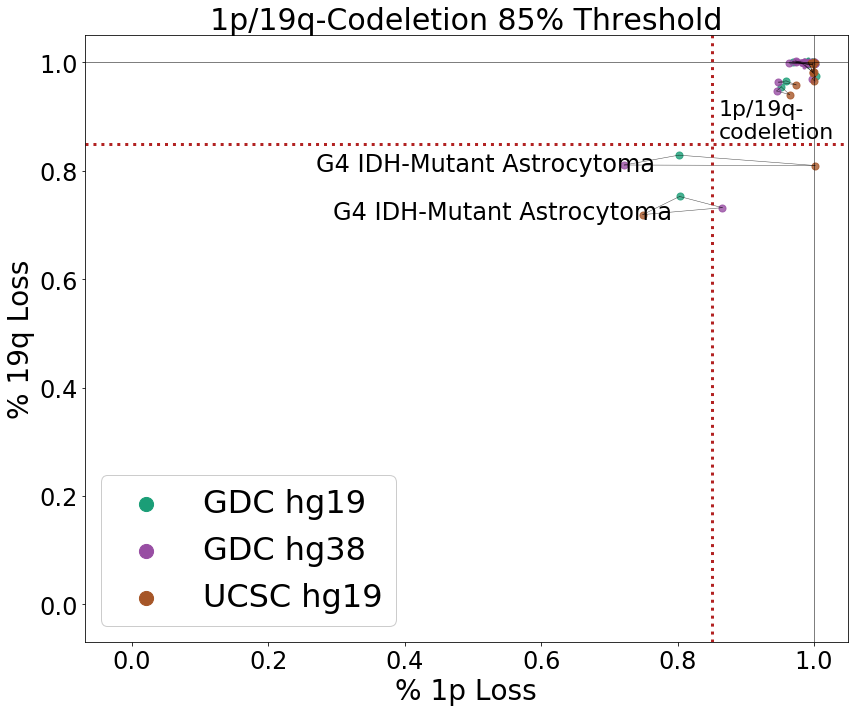

In [5]:
gdc_hg19_cols = ['1p_GDC_hg19', '19q_GDC_hg19']
gdc_hg38_cols = ['1p_GDC_hg38', '19q_GDC_hg38']
ucsc_hg19_cols = ['1p_UCSC_hg19', '19q_UCSC_hg19']

rename_dict = {'1p_GDC_hg19':'1p', '19q_GDC_hg19':'19q', 
               '1p_GDC_hg38':'1p', '19q_GDC_hg38':'19q', 
               '1p_UCSC_hg19':'1p', '19q_UCSC_hg19':'19q'}

_tcga_hg19_oligo_df = tcga_1p19q_df[gdc_hg19_cols].loc[oligo_candidates_idxs].rename(columns=rename_dict)
_tcga_hg19_oligo_df.index = _tcga_hg19_oligo_df.index + '_tcga19'

_tcga_hg38_oligo_df = tcga_1p19q_df[gdc_hg38_cols].loc[oligo_candidates_idxs].rename(columns=rename_dict)
_tcga_hg38_oligo_df.index = _tcga_hg38_oligo_df.index + '_tcga38'

_ucsc_hg19_oligo_df = tcga_1p19q_df[ucsc_hg19_cols].loc[oligo_candidates_idxs].rename(columns=rename_dict)
_ucsc_hg19_oligo_df.index = _ucsc_hg19_oligo_df.index + '_ucsc19'

plot_joint_oligo_df = pd.concat([_tcga_hg19_oligo_df, _tcga_hg38_oligo_df, _ucsc_hg19_oligo_df])
plot_df = plot_joint_oligo_df + np.random.normal(0, 0.002, plot_joint_oligo_df.shape)

## plot
fig, ax = plt.subplots(figsize=(12,10))
colors = ['#1b9e77', '#984ea3', '#a65628']


label_dict = {'ucsc19':'UCSC hg19', 'tcga19':'GDC hg19', 'tcga38':'GDC hg38'}
xthresh = 0.9775
ythresh = 0.99
for i, dataset in enumerate(['tcga19', 'tcga38', 'ucsc19']):
    dataset_idxs = [x for x in plot_df.index if dataset in x]
    
    _plot_df = plot_df.loc[dataset_idxs]
    _temp_plot_df = _plot_df.loc[(_plot_df['1p'] < -xthresh) & (_plot_df['19q'] < -ythresh)]
    plt.scatter(_temp_plot_df['1p'].abs(), _temp_plot_df['19q'].abs(), color=colors[i], 
                label=label_dict[dataset], alpha=0.8, s=10)
        
    _temp_plot_df = _plot_df.loc[(_plot_df['1p'] >= -xthresh) | (_plot_df['19q'] >= -ythresh)]
    plt.scatter(_temp_plot_df['1p'].abs(), _temp_plot_df['19q'].abs(), color=colors[i], 
                label=None, alpha=0.8, s=50)

all_split_idxs = list(set([x.split('_')[0] for x in plot_df.index]))
print(len(all_split_idxs))

for idx in all_split_idxs:
    xs = [plot_df.loc[idx+'_ucsc19'].abs()['1p'], plot_df.loc[idx+'_tcga19'].abs()['1p']]
    ys = [plot_df.loc[idx+'_ucsc19'].abs()['19q'], plot_df.loc[idx+'_tcga19'].abs()['19q']]
    if not all(x > xthresh for x in xs) or not all(y > ythresh for y in ys):
        plt.plot(xs, ys, c='k', linestyle='-', marker=None, alpha=0.7, linewidth=0.5)

    xs = [plot_df.loc[idx+'_ucsc19'].abs()['1p'], plot_df.loc[idx+'_tcga38'].abs()['1p']]
    ys = [plot_df.loc[idx+'_ucsc19'].abs()['19q'], plot_df.loc[idx+'_tcga38'].abs()['19q']]
    if not all(x > xthresh for x in xs) or not all(y > ythresh for y in ys):
        plt.plot(xs, ys, c='k', linestyle='-', marker=None, alpha=0.7, linewidth=0.5)
    
    xs = [plot_df.loc[idx+'_tcga19'].abs()['1p'], plot_df.loc[idx+'_tcga38'].abs()['1p']]
    ys = [plot_df.loc[idx+'_tcga19'].abs()['19q'], plot_df.loc[idx+'_tcga38'].abs()['19q']]
    if not all(x > xthresh for x in xs) or not all(y > ythresh for y in ys):
        plt.plot(xs, ys, c='k', linestyle='-', marker=None, alpha=0.7, linewidth=0.5)

plt.title('1p/19q-Codeletion 85% Threshold', fontsize=30)    
plt.axvline(x=1, color='black', linewidth=0.5, linestyle='-')
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='-')

plt.axvline(x=0.85, color='firebrick', linewidth=3, linestyle=':')
plt.axhline(y=0.85, color='firebrick', linewidth=3, linestyle=':')

plt.text(x = 0.86, y=0.86, s='1p/19q-\ncodeletion', color='black', fontsize=22)
plt.text(x = 0.295, y=0.71, s='G4 IDH-Mutant Astrocytoma', color='black', fontsize=24)
plt.text(x = 0.27, y=0.80, s='G4 IDH-Mutant Astrocytoma', color='black', fontsize=24)

legend = plt.legend(fontsize=32, markerscale=2, loc='lower left', framealpha=1)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [200]
            
plt.xlabel('% 1p Loss', fontsize=28)
plt.ylabel('% 19q Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(-0.069, 1.05)
plt.ylim(-0.069, 1.05)
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


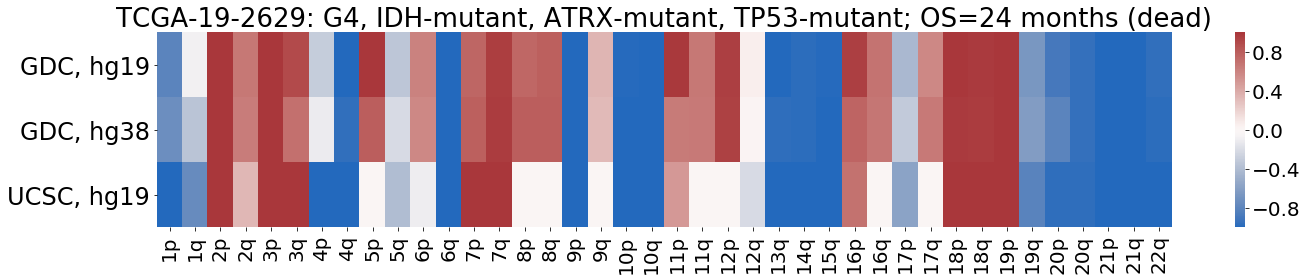

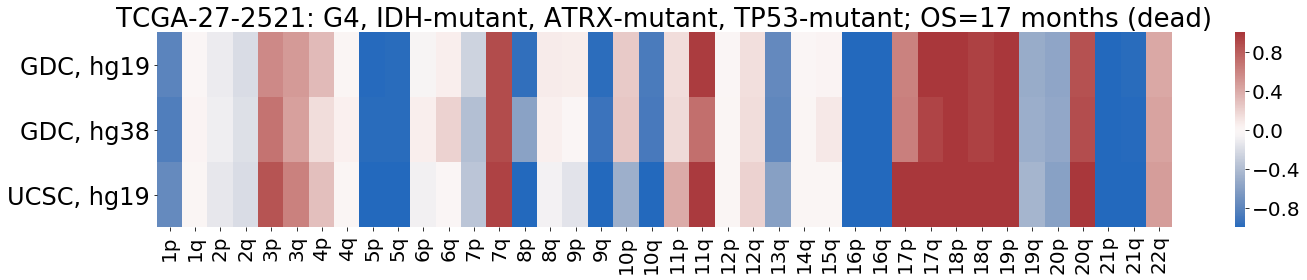

In [6]:
# tcga chrarm scna data 
ucsc_hg19_scna_df = pd.read_csv('../data/chrarm_data/ucsc_hg19_tcga_train_scna_chrarm_level.csv', index_col=0)
tcga_hg19_scna_df = pd.read_csv('../data/chrarm_data/gdc_hg19_tcga_train_scna_chrarm_level.csv', index_col=0)
tcga_hg38_scna_df = pd.read_csv('../data/chrarm_data/gdc_hg38_tcga_train_scna_chrarm_level.csv', index_col=0)

# plot
plot_idxs = ['TCGA-19-2629', 'TCGA-27-2521']
title_dict = {'TCGA-27-2521':'TCGA-27-2521: G4, IDH-mutant, ATRX-mutant, TP53-mutant; OS=17 months (dead)',
             'TCGA-19-2629':'TCGA-19-2629: G4, IDH-mutant, ATRX-mutant, TP53-mutant; OS=24 months (dead)'}
for idx in plot_idxs:
    title = title_dict[idx]
    plot_df = pd.DataFrame([tcga_hg19_scna_df.loc[idx],tcga_hg38_scna_df.loc[idx],ucsc_hg19_scna_df.loc[idx]],
                            index=['GDC, hg19', 'GDC, hg38', 'UCSC, hg19' ])[COL_ORDER]
    # plot
    fig, ax = plt.subplots(figsize=(20, 4))
    sns.heatmap(plot_df, cmap="vlag", vmin=-1, vmax=1, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=24)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=20)
    plt.title(title, fontsize=26)
    plt.tight_layout()

# Figure 2B

In [7]:
## chromosomme arm data
# tcga train
tcga_1p19q_df = pd.read_csv('../data/chrarm_data/tcga_train_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)
rename_dict = {'1p_GDC_hg19':'1p', '1q_GDC_hg19':'1q', '19p_GDC_hg19':'19p', '19q_GDC_hg19':'19q'}
tcga_1p19q_df = tcga_1p19q_df.rename(columns=rename_dict)[['1p', '1q', '19p', '19q']]

# jonsson et al. validation
jonsson_1p19q_df = pd.read_csv('../data/chrarm_data/jonsson_val_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)

# capper et al. validation
capper_1p19q_df = pd.read_csv('../data/chrarm_data/capper_val_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)

## subtype data
jonsson_test_labels = pd.read_csv('../data/clinical_data/jonsson_val_clinical_data.csv', index_col=0)
capper_test_labels = pd.read_csv('../data/clinical_data/capper_val_clinical_data.csv', index_col=0)

In [8]:
from sklearn.metrics import matthews_corrcoef
result_dict = {}

loss_chromarm_df_dict = {'TCGA':tcga_1p19q_df, 'Jonsson et al.':jonsson_1p19q_df, 'Capper et al.':capper_1p19q_df}

tcga_train_oligo_idxs = tcga_clinical_df.loc[tcga_clinical_df['WHO_2021_Subtype'] == 'Oligodendroglioma'].index
jonsson_oligo_idxs = jonsson_test_labels.loc[jonsson_test_labels['WHO_2016_Subtype'] == 'IDHmut-codel'].index
capper_oligo_idxs = capper_test_labels.loc[capper_test_labels['WHO_2016_Subtype'] == 'IDHmut-codel'].index

gt_oligo_dict = {'TCGA':tcga_train_oligo_idxs, 'Jonsson et al.':jonsson_oligo_idxs,'Capper et al.':capper_oligo_idxs}

datasets = ['TCGA', 'Jonsson et al.', 'Capper et al.']
thresholds = np.linspace(0.2, .99, 80)
thresholds = [np.round(x, 2) for x in thresholds]
for dataset in tqdm(datasets):
    result_dict[dataset] = {}
    for thresh in tqdm(thresholds):

        loss_chrarm_df = loss_chromarm_df_dict[dataset]
        oligo_df = loss_chrarm_df.loc[(loss_chrarm_df['1p'] < -thresh)
                                                      & (loss_chrarm_df['1q'] >= -thresh)
                                                      & (loss_chrarm_df['19p'] >= -thresh)
                                                      & (loss_chrarm_df['19q'] < -thresh)]

        label_df =  pd.DataFrame(data=np.zeros(len(loss_chrarm_df.index)), index=loss_chrarm_df.index, columns=['Pred'])
        label_df.loc[oligo_df.index, 'Pred'] = 1

        gt_oligo_idxs = gt_oligo_dict[dataset]
        label_df['GT'] = 0
        label_df.loc[gt_oligo_idxs, 'GT'] = 1

        # MCC
        mcc = matthews_corrcoef(label_df['GT'], label_df['Pred'])
        result_dict[dataset][thresh] = mcc

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


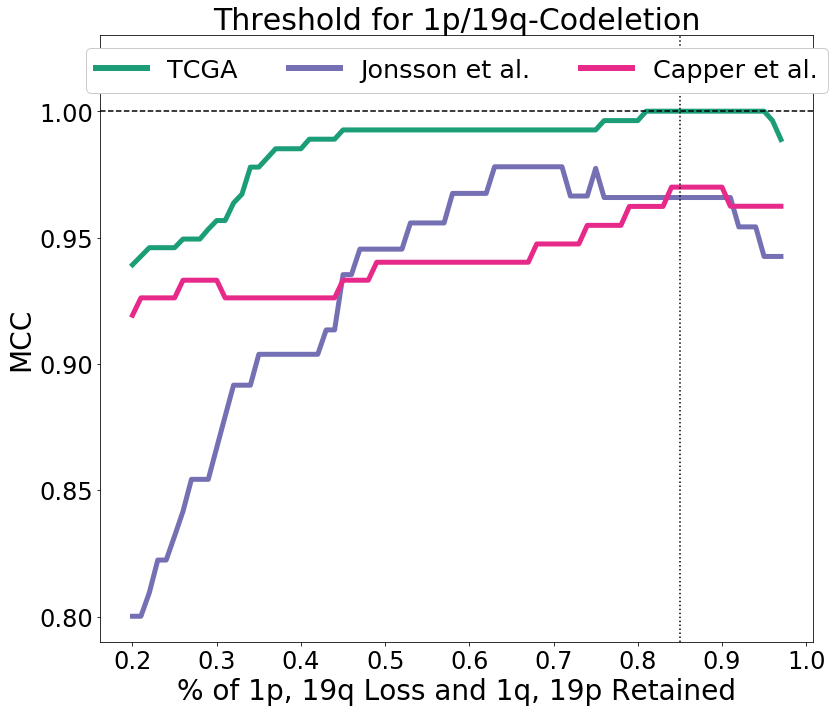

In [9]:
result_df = pd.DataFrame.from_dict(data=result_dict, orient='index').T
result_df = result_df.drop([0.98, 0.99])

datasets = ['TCGA', 'Jonsson et al.', 'Capper et al.']
color_dict = {'TCGA': '#1b9e77', 'Jonsson et al.': '#7570b3', 'Capper et al.': '#e7298a'}

fig, ax = plt.subplots(figsize=(12,10))

for dataset in datasets:
    ax.plot(result_df.index, result_df[dataset], color=color_dict[dataset], 
                       label=dataset, 
                       linestyle='-',
                       linewidth=5)

ax.set_ylim(0.79, 1.03)

ax.axvline(0.85, color='black', linestyle=':')
ax.axhline(1, color='black', linestyle='--')

ax.set_title('Threshold for 1p/19q-Codeletion', fontsize=30)
ax.set_ylabel('MCC', fontsize=28)
ax.set_xlabel('% of 1p, 19q Loss and 1q, 19p Retained', fontsize=28)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
leg = ax.legend(fontsize=25.5, markerscale=3, ncol=3, framealpha=1,  loc="upper center")

for legobj in leg.legendHandles:
    legobj.set_linewidth(6.0)

plt.tight_layout()

# Figure 2C

In [10]:
## TCGA Training +7-10, EGFR Amp, & clinical data
tcga_7_10_egfr_df = pd.read_csv('../data/chrarm_data/tcga_train_7-10-EGFR_avg_chrarm_gainloss.csv', index_col=0)
tcga_clinical_df = pd.read_csv('../data/clinical_data/tcga_train_clinical_data.csv', index_col=0)

## TCGA excluded WT +7-10, EGFR Amp, & clinical data
tcga_exclude_7_10_egfr_df = pd.read_csv('../data/chrarm_data/tcga_exclude_7-10-EGFR_avg_chrarm_gainloss.csv', 
                                        index_col=0)
tcga_exclude_clinical_df = pd.read_csv('../data/clinical_data/tcga_exclude_clinical_data.csv', index_col=0)

## TCGA +7-10, EGFR Amp, & clinical data combined
wt_labels = ['IDH-Wildtype Glioblastoma', 'IDH-Wildtype, Pediatric-Type', 'IDH-Wildtype, NEC']
wt_exclude_idxs = tcga_exclude_clinical_df.loc[tcga_exclude_clinical_df['WHO_2021_Subtype'].isin(wt_labels)].index
tcga_7_10_egfr_df = tcga_7_10_egfr_df.append(tcga_exclude_7_10_egfr_df.loc[wt_exclude_idxs])
tcga_clinical_7_10_egfr_df = tcga_clinical_df.append(tcga_exclude_clinical_df.loc[wt_exclude_idxs])

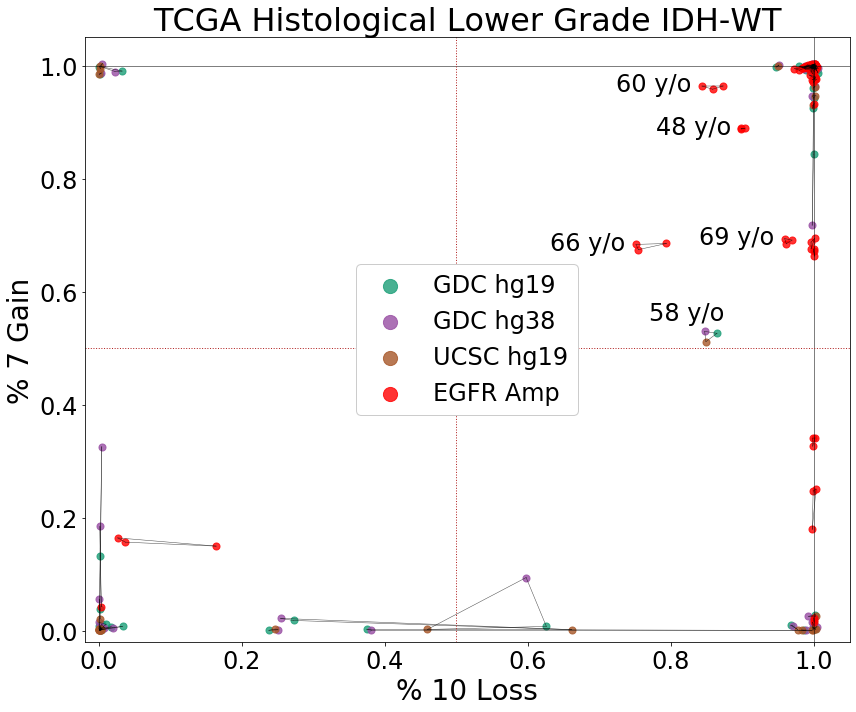

In [11]:
### data ####
wt_labels = ['IDH-Wildtype Glioblastoma', 'IDH-Wildtype, Pediatric-Type', 'IDH-Wildtype, NEC']
lgg_wt_idxs = tcga_clinical_7_10_egfr_df.loc[((tcga_clinical_7_10_egfr_df['WHO_2021_Subtype'].isin(wt_labels)) 
                              & (tcga_clinical_7_10_egfr_df['Histologic_Grade'] != 'G4'))].index
## idxs
lgg_tcga_7_10_egfr_df = tcga_7_10_egfr_df.loc[lgg_wt_idxs]
rename_dict = {'7_GDC_hg19':'7', '10_GDC_hg19':'10','EGFR_GDC_hg19':'EGFR'}
_gdc_hg19_df = lgg_tcga_7_10_egfr_df[rename_dict.keys()].rename(columns=rename_dict)
_gdc_hg19_df.index = _gdc_hg19_df.index + '_tcga19'

rename_dict = {'7_GDC_hg38':'7', '10_GDC_hg38':'10', 'EGFR_GDC_hg38':'EGFR'}
_gdc_hg38_df = lgg_tcga_7_10_egfr_df[rename_dict.keys()].rename(columns=rename_dict)
_gdc_hg38_df.index = _gdc_hg38_df.index + '_tcga38'

rename_dict = {'7_UCSC_hg19':'7', '10_UCSC_hg19':'10', 'EGFR_UCSC_hg19':'EGFR'}
_ucsc_hg19_df = lgg_tcga_7_10_egfr_df[rename_dict.keys()].rename(columns=rename_dict)
_ucsc_hg19_df.index = _ucsc_hg19_df.index + '_ucsc19'

joint_710_plot_df = pd.concat([_gdc_hg19_df, _gdc_hg38_df, _ucsc_hg19_df])
plot_df = joint_710_plot_df + np.random.normal(0, 0.002, joint_710_plot_df.shape)

## plot
fig, ax = plt.subplots(figsize=(12,10))
colors = ['#1b9e77', '#984ea3', '#a65628']

label_dict = {'ucsc19':'UCSC hg19', 'tcga19':'GDC hg19', 'tcga38':'GDC hg38'}

for i, dataset in enumerate([ 'tcga19', 'tcga38', 'ucsc19']):
    dataset_idxs = [x for x in plot_df.index if dataset in x]
    no_egfr_plot_df = plot_df.loc[plot_df['EGFR'] <= 1.5]
    _plot_df = no_egfr_plot_df.loc[no_egfr_plot_df.index.isin(dataset_idxs)]
    plt.scatter(_plot_df['10'].abs(), _plot_df['7'].abs(), color=colors[i], 
                label=label_dict[dataset], alpha=0.8, s=50)
    
for i, dataset in enumerate([ 'tcga19', 'tcga38', 'ucsc19']):
    dataset_idxs = [x for x in plot_df.index if dataset in x]
    egfr_plot_df = plot_df.loc[plot_df['EGFR'] > 1.5]
    _plot_df = egfr_plot_df.loc[egfr_plot_df.index.isin(dataset_idxs)]
    plt.scatter(_plot_df['10'].abs(), _plot_df['7'].abs(), color='red', 
                label='EGFR Amp', alpha=0.8, s=50)

all_split_idxs = list(set([x.split('_')[0] for x in plot_df.index]))
for idx in all_split_idxs:
    xs = [plot_df.loc[idx+'_ucsc19'].abs()['10'], plot_df.loc[idx+'_tcga19'].abs()['10']]
    ys = [plot_df.loc[idx+'_ucsc19'].abs()['7'], plot_df.loc[idx+'_tcga19'].abs()['7']]
    plt.plot(xs, ys, c='k', linestyle='-', marker=None, alpha=0.7, linewidth=0.5)

    xs = [plot_df.loc[idx+'_ucsc19'].abs()['10'], plot_df.loc[idx+'_tcga38'].abs()['10']]
    ys = [plot_df.loc[idx+'_ucsc19'].abs()['7'], plot_df.loc[idx+'_tcga38'].abs()['7']]
    plt.plot(xs, ys, c='k', linestyle='-', marker=None, alpha=0.7, linewidth=0.5)
    
    xs = [plot_df.loc[idx+'_tcga19'].abs()['10'], plot_df.loc[idx+'_tcga38'].abs()['10']]
    ys = [plot_df.loc[idx+'_tcga19'].abs()['7'], plot_df.loc[idx+'_tcga38'].abs()['7']]
    plt.plot(xs, ys, c='k', linestyle='-', marker=None, alpha=0.7, linewidth=0.5)

_idxs = plot_df.loc[(plot_df['7'] > 0.5) & (plot_df['10'] < -0.5) 
                    & (plot_df['7'] < 0.98) & (plot_df['10'] > -0.98)].index
_idxs = [x for x in _idxs if 'ucsc' in x]

age_dict = {x:tcga_clinical_7_10_egfr_df.loc[x[:-7]]['Age'] for x in _idxs}

for idx in age_dict:
    x, y = plot_df.loc[idx].abs()['10'], plot_df.loc[idx].abs()['7']
    if idx == 'TCGA-E1-A7Z2_ucsc19':
        plt.text(x = x - 0.08, y=y + 0.038, s=str(int(age_dict[idx])) + ' y/o', color='black', fontsize=24)
    elif idx == 'TCGA-CS-6188_ucsc19':
        plt.text(x = x - 0.125, y=y - 0.01, s=str(int(age_dict[idx])) + ' y/o', color='black', fontsize=24)
    else:
        plt.text(x = x - 0.12, y=y - 0.01, s=str(int(age_dict[idx])) + ' y/o', color='black', fontsize=24)

plt.title('TCGA Histological Lower Grade IDH-WT', fontsize=32)    
plt.axvline(x=1, color='black', linewidth=0.5, linestyle='-')
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='-')

plt.axvline(x=0.5, color='firebrick', linewidth=1, linestyle=':')
plt.axhline(y=0.5, color='firebrick', linewidth=1, linestyle=':')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=24, markerscale=2, loc='center', framealpha=1)

plt.xlabel('% 10 Loss', fontsize=28)
plt.ylabel('% 7 Gain', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(-0.02, 1.05)
plt.ylim(-0.02, 1.05)
plt.tight_layout()

# Figure 2D

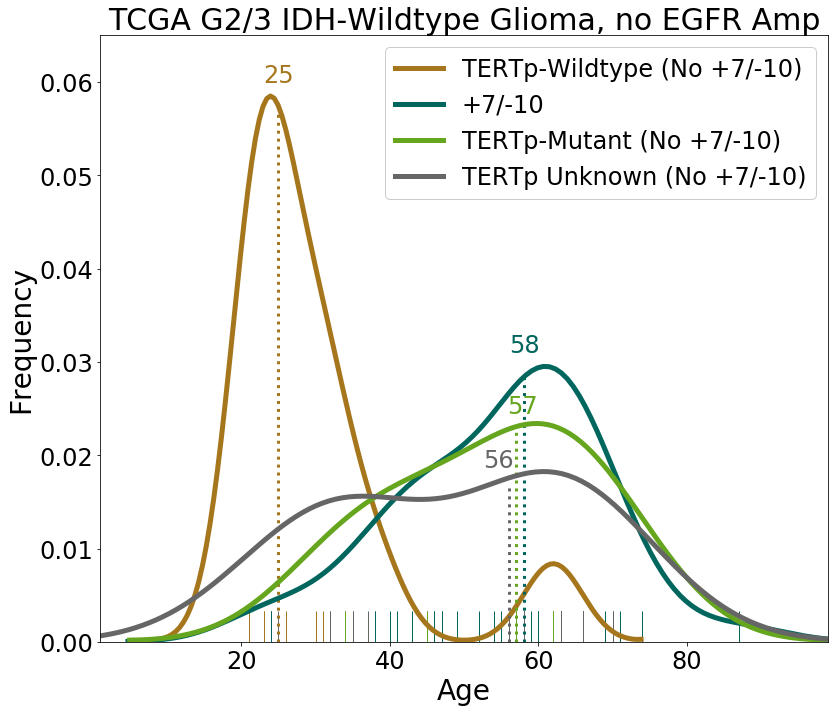

In [12]:
wt_labels = ['IDH-Wildtype Glioblastoma', 'IDH-Wildtype, Pediatric-Type', 'IDH-Wildtype, NEC']
wt_tert_lgg_wt_idxs = tcga_clinical_7_10_egfr_df.loc[((tcga_clinical_7_10_egfr_df['WHO_2021_Subtype']\
                                                               .isin(wt_labels)) 
                                                      & (tcga_clinical_7_10_egfr_df['Histologic_Grade'] != 'G4')
                                                      & (tcga_clinical_7_10_egfr_df['EGFR_GDC_hg19'] == 'No Amp')
                                                      & (tcga_clinical_7_10_egfr_df['TERTp'] == 'WT'))].index

mut_tert_lgg_wt_idxs = tcga_clinical_7_10_egfr_df.loc[((tcga_clinical_7_10_egfr_df['WHO_2021_Subtype']\
                                                                .isin(wt_labels)) 
                                                       & (tcga_clinical_7_10_egfr_df['Histologic_Grade'] != 'G4')
                                                       & (tcga_clinical_7_10_egfr_df['EGFR_GDC_hg19'] == 'No Amp')
                                                       & (tcga_clinical_7_10_egfr_df['TERTp'] == 'Mutant'))].index


all_tert_lgg_wt_idxs = tcga_clinical_7_10_egfr_df.loc[((tcga_clinical_7_10_egfr_df['WHO_2021_Subtype']\
                                                                .isin(wt_labels)) 
                                                       & (tcga_clinical_7_10_egfr_df['Histologic_Grade'] != 'G4')
                                                       & (tcga_clinical_7_10_egfr_df['EGFR_GDC_hg19'] == 'No Amp'))
                                                     ].index

unknown_tert_lgg_wt_idxs = [x for x in all_tert_lgg_wt_idxs if x not in wt_tert_lgg_wt_idxs 
                            and x not in mut_tert_lgg_wt_idxs]

# plot
fig, ax = plt.subplots(figsize=(12,10))

idxs_dict = {'wt_tert':{'idxs':wt_tert_lgg_wt_idxs, '+7/-10':False, 'color':'#a6761d', 
                        'label':'TERTp-Wildtype (No +7/-10)'},
             'all_tert':{'idxs':all_tert_lgg_wt_idxs, '+7/-10':True, 'color':'#01665e', 
                         'label':'+7/-10'},
             'mut_tert':{'idxs':mut_tert_lgg_wt_idxs, '+7/-10':False, 'color':'#66a61e', 
                         'label':'TERTp-Mutant (No +7/-10)'},
             'unknown_tert':{'idxs':unknown_tert_lgg_wt_idxs, '+7/-10':False, 'color':'#666666', 
                             'label':'TERTp Unknown (No +7/-10)'}}

pos_dict = {'wt_tert':{'textx':2, 'texty':0.06, 'linetop':[0, 0.057]},
             'all_tert':{'textx':2, 'texty':0.031, 'linetop':[0, 0.0285]},
             'mut_tert':{'textx':1.2, 'texty':0.0245, 'linetop':[0, 0.023]},
             'unknown_tert':{'textx':3.5, 'texty':0.0187, 'linetop':[0, 0.017]}}
thresh = 0.5
for idxs_key in idxs_dict:
    color, label = idxs_dict[idxs_key]['color'], idxs_dict[idxs_key]['label']
    _joint_df = lgg_tcga_7_10_egfr_df.loc[idxs_dict[idxs_key]['idxs']]
    
    if idxs_dict[idxs_key]['+7/-10']:
        _wt_idxs = _joint_df.loc[(_joint_df['7_UCSC_hg19'] > thresh) 
                                         | (_joint_df['10_UCSC_hg19'] < -thresh)].index
    else:
        _wt_idxs = _joint_df.loc[(_joint_df['7_UCSC_hg19'] <= thresh) 
                                            | (_joint_df['10_UCSC_hg19'] >= -thresh)].index
    
    age = tcga_clinical_7_10_egfr_df.loc[_wt_idxs][['Age']]
    
    sns.distplot(age, hist=False, color=color, label=label,  kde_kws=dict(linewidth=5), rug=True, bins=15)
    
    x, y = pos_dict[idxs_key]['textx'], pos_dict[idxs_key]['texty']
    top_pos = pos_dict[idxs_key]['linetop']
    plt.text(x = age['Age'].median()-x, y=y, s=int(age['Age'].median()), color=color, fontsize=24)
    ax.plot([age['Age'].median(), age['Age'].median()], top_pos, color=color, linestyle=':', linewidth=3)

ax.set_title('TCGA G2/3 IDH-Wildtype Glioma, no EGFR Amp', fontsize=30)
ax.legend(fontsize=24, markerscale=4, ncol=1, framealpha=1, loc="upper right")
ax.set_xlim(1, 99)
ax.set_ylim(0, 0.065)
ax.set_ylabel('Frequency', fontsize=28)
ax.set_xlabel('Age', fontsize=28)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
plt.tight_layout()

# Figure 2E

In [13]:
## get IDH-wildtype indices in validation sets
# TCGA val
tcga_val_clinical_df = pd.read_csv('../data/clinical_data/tcga_val_clinical_data.csv', index_col=0)
wt_tcga_val_idxs = tcga_val_clinical_df.loc[tcga_val_clinical_df['IDH & 1p/19q Status'] == 'IDHwt'].index

# GLASS
glass_clinical_df = pd.read_csv('../data/clinical_data/glass_val_clinical_data.csv', index_col=0)
wt_glass_val_idxs = glass_clinical_df.loc[glass_clinical_df['idh_codel_subtype'] == 'IDHwt'].index

# Jonsson et al.
jonsson_clinical_df = pd.read_csv('../data/clinical_data/jonsson_val_clinical_data.csv', index_col=0)
wt_jonsson_val_idxs = jonsson_clinical_df.loc[jonsson_clinical_df['WHO_2016_Subtype'] == 'IDHwt'].index

# Capper et al.
capper_clinical_df = pd.read_csv('../data/clinical_data/capper_val_clinical_data.csv', index_col=0)
wt_capper_val_idxs = capper_clinical_df.loc[capper_clinical_df['WHO_2016_Subtype'] == 'IDHwt'].index

In [14]:
## Get SCNA data from average gain of 7 and average loss of 10 for each validation dataset
# TCGA Val
tcga_val_7_10_egfr_df = pd.read_csv('../data/chrarm_data/tcga_val_710_egfr_avg_chrarm_gainloss.csv', index_col=0)
tcga_wt_val_7_10_egfr_df = tcga_val_7_10_egfr_df.loc[wt_tcga_val_idxs]
tcga_wt_val_7_10_egfr_df['Dataset'] = 'TCGA Val'

# GLASS
glass_val_7_10_egfr_df = pd.read_csv('../data/chrarm_data/glass_val_710_egfr_avg_chrarm_gainloss.csv', index_col=0)
glass_wt_val_7_10_egfr_df = glass_val_7_10_egfr_df.loc[wt_glass_val_idxs]
glass_wt_val_7_10_egfr_df['Dataset'] = 'GLASS'

# Jonsson et al.
jonsson_val_7_10_egfr_df = pd.read_csv('../data/chrarm_data/jonsson_val_710_egfr_avg_chrarm_gainloss.csv', index_col=0)
jonsson_wt_val_7_10_egfr_df = jonsson_val_7_10_egfr_df.loc[wt_jonsson_val_idxs]
jonsson_wt_val_7_10_egfr_df['Dataset'] = 'Jonsson et al.'

# Capper et al.
capper_val_7_10_egfr_df = pd.read_csv('../data/chrarm_data/capper_val_710_egfr_avg_chrarm_gainloss.csv', index_col=0)
capper_wt_val_7_10_egfr_df = capper_val_7_10_egfr_df.loc[wt_capper_val_idxs]
capper_wt_val_7_10_egfr_df['Dataset'] = 'Capper et al.'

# Join +7/-10 data for all validation datasets
wt_big_710_scna_df = pd.concat([tcga_wt_val_7_10_egfr_df, 
                                glass_wt_val_7_10_egfr_df, 
                                jonsson_wt_val_7_10_egfr_df, 
                                capper_wt_val_7_10_egfr_df],
                              axis=0)

TCGA Val 146
GLASS 143
Jonsson et al. 319


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Capper et al. 298


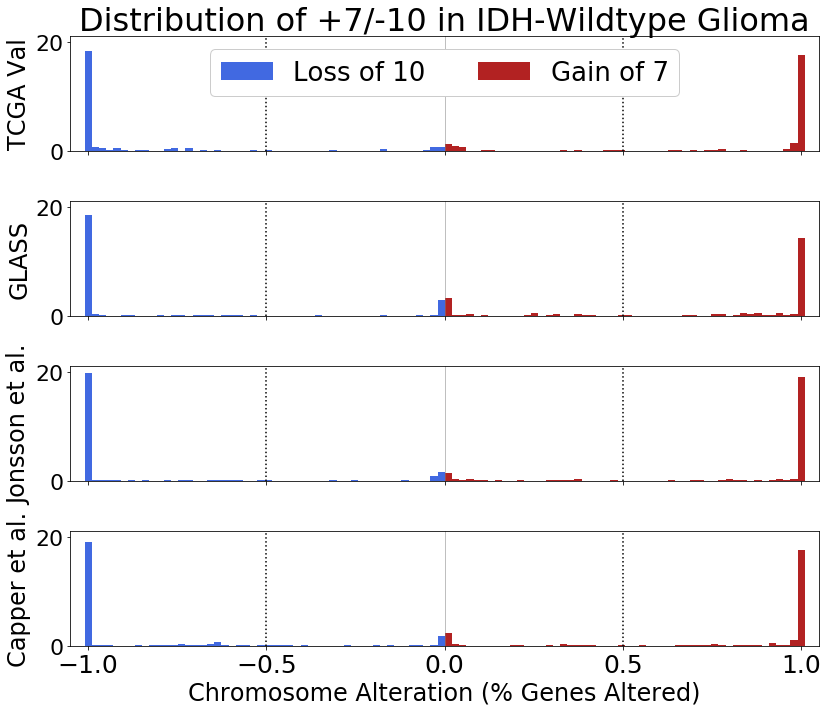

In [15]:
#### plot ######
fig, ax = plt.subplots(4, figsize=(12,10), sharex=True, gridspec_kw={'height_ratios': [1,1,1,1]})
thesh7 = 0.5
thesh10 = 0.5

_wt_big_710_scna_df = wt_big_710_scna_df.copy()
_wt_big_710_scna_df['7'] = _wt_big_710_scna_df['7'] + 0.01
_wt_big_710_scna_df['10'] = _wt_big_710_scna_df['10'] - 0.01

for i, dataset in enumerate(wt_big_710_scna_df['Dataset'].unique()):
    plot_df = _wt_big_710_scna_df[_wt_big_710_scna_df['Dataset'] == dataset]
    
    ax[i].hist([plot_df['7'], plot_df['10']], stacked=True, bins=100, color=['firebrick', 'royalblue'], density=True)
    print(dataset, len(plot_df))
    ax[i].set_ylabel(dataset, fontsize=24)
    
    ax[i].axvline(-thesh10, color='k', linestyle=':')
    ax[i].axvline(thesh7, color='k', linestyle=':')
    ax[i].axvline(0, color='grey', linestyle='-', linewidth=0.5)
    
    ax[i].tick_params(axis='y', labelsize=22)
    
    ax[i].set_xlim(-1.05,1.05)
    ax[i].set_ylim(0,21)


ax[0].set_title('Distribution of +7/-10 in IDH-Wildtype Glioma', fontsize=32)
ax[3].set_xlabel('Chromosome Alteration (% Genes Altered)', fontsize=24)
plt.xticks([-1, -0.5, 0, 0.5, 1], fontsize=25)

import matplotlib.patches as mpatches
circ1 = mpatches.Patch( facecolor='royalblue',alpha=1,hatch='',label='Loss of 10')
circ2= mpatches.Patch( facecolor='firebrick',alpha=1,hatch='',label='Gain of 7')
ax[0].legend(handles = [circ1,circ2], fontsize=26, bbox_to_anchor=(0.5,1), ncol=2, loc="upper center", framealpha=1)

plt.tight_layout()

# Figure 2F

In [16]:
## TCGA Training +7-10, EGFR Amp, & clinical data
tcga_7_10_egfr_df = pd.read_csv('../data/chrarm_data/tcga_train_7-10-EGFR_avg_chrarm_gainloss.csv', index_col=0)
tcga_clinical_df = pd.read_csv('../data/clinical_data/tcga_train_clinical_data.csv', index_col=0)

## TCGA excluded WT +7-10, EGFR Amp, & clinical data
tcga_exclude_7_10_egfr_df = pd.read_csv('../data/chrarm_data/tcga_exclude_7-10-EGFR_avg_chrarm_gainloss.csv', 
                                        index_col=0)
tcga_exclude_clinical_df = pd.read_csv('../data/clinical_data/tcga_exclude_clinical_data.csv', index_col=0)

## TCGA +7-10, EGFR Amp, & clinical data combined
wt_labels = ['IDH-Wildtype Glioblastoma', 'IDH-Wildtype, Pediatric-Type', 'IDH-Wildtype, NEC']
wt_exclude_idxs = tcga_exclude_clinical_df.loc[tcga_exclude_clinical_df['WHO_2021_Subtype'].isin(wt_labels)].index
tcga_7_10_egfr_df = tcga_7_10_egfr_df.append(tcga_exclude_7_10_egfr_df.loc[wt_exclude_idxs])
tcga_clinical_7_10_egfr_df = tcga_clinical_df.append(tcga_exclude_clinical_df.loc[wt_exclude_idxs])

tcga_clinical_7_10_egfr_df = pd.concat([tcga_clinical_7_10_egfr_df.drop(columns=['EGFR_GDC_hg19']),
                                                                        tcga_7_10_egfr_df], axis=1, join='inner')


In [17]:
## LGG WT indices
lgg_wt_idxs = tcga_clinical_7_10_egfr_df.loc[(tcga_clinical_7_10_egfr_df['WHO_2021_Subtype'].isin(wt_labels)) 
                                             & (tcga_clinical_7_10_egfr_df['Histologic_Grade'] != 'G4')].index
print('LGG WT (GDC hg19):\t', len(lgg_wt_idxs))
print('---------------------------')

# 7/10
hg19_710_idxs = tcga_clinical_7_10_egfr_df.loc[(tcga_clinical_7_10_egfr_df['7_GDC_hg19'] > 0.5) 
                             & (tcga_clinical_7_10_egfr_df['10_GDC_hg19'] < -0.5)
                             & (tcga_clinical_7_10_egfr_df.index.isin(lgg_wt_idxs))].index
print('7/10 (GDC hg19):\t', len(hg19_710_idxs))

# egfr amp
hg19_egfr_amp_idxs = tcga_clinical_7_10_egfr_df.loc[(tcga_clinical_7_10_egfr_df['EGFR_GDC_hg19'] == 2) 
                                  & (tcga_clinical_7_10_egfr_df.index.isin(lgg_wt_idxs))].index
print('EGFR (GDC hg19):\t', len(hg19_egfr_amp_idxs))

# tertp
hg19_tertp_idxs = tcga_clinical_7_10_egfr_df.loc[(tcga_clinical_7_10_egfr_df['TERTp'] == 'Mutant')
                                 & (tcga_clinical_7_10_egfr_df.index.isin(lgg_wt_idxs))].index
print('TERTp (GDC hg19):\t', len(hg19_tertp_idxs))

LGG WT (GDC hg19):	 91
---------------------------
7/10 (GDC hg19):	 61
EGFR (GDC hg19):	 37
TERTp (GDC hg19):	 37


In [18]:
hg19_all_idxs = [x for x in hg19_710_idxs if x in hg19_egfr_amp_idxs and x in hg19_tertp_idxs]
print('All:\t\t', len(hg19_all_idxs))

hg19_710_egfr_idxs = [x for x in hg19_710_idxs if x in hg19_egfr_amp_idxs and x not in hg19_tertp_idxs]
print('7/10, EGFR:\t', len(hg19_710_egfr_idxs))
hg19_710_tertp_idxs = [x for x in hg19_710_idxs if x not in hg19_egfr_amp_idxs and x in hg19_tertp_idxs]
print('7/10, TERTp:\t', len(hg19_710_tertp_idxs))
hg19_egfr_tertp_idxs = [x for x in hg19_egfr_amp_idxs if x in hg19_tertp_idxs and x not in hg19_710_idxs]
print('EGFR, TERTp:\t', len(hg19_egfr_tertp_idxs))

hg19_710_only_idxs = [x for x in hg19_710_idxs if x not in hg19_egfr_amp_idxs and x not in hg19_tertp_idxs]
print('7/10:\t\t', len(hg19_710_only_idxs))
hg19_egfr_only_idxs = [x for x in hg19_egfr_amp_idxs if x not in hg19_tertp_idxs and x not in hg19_710_idxs]
print('EGFR:\t\t', len(hg19_egfr_only_idxs))
hg19_tertp_only_idxs = [x for x in hg19_tertp_idxs if x not in hg19_egfr_amp_idxs and x not in hg19_710_idxs]
print('TERTp:\t\t', len(hg19_tertp_only_idxs))

## Find those with none and the unknown ##
idxs_list = [hg19_all_idxs, hg19_710_egfr_idxs, hg19_710_tertp_idxs, hg19_egfr_tertp_idxs, 
             hg19_710_only_idxs, hg19_egfr_only_idxs, hg19_tertp_only_idxs]
mGBM_idxs = [item for sublist in idxs_list for item in sublist]
exclude_idxs = [x for x in lgg_wt_idxs if x not in mGBM_idxs]

pedatric_like_num = tcga_clinical_7_10_egfr_df.loc[exclude_idxs]['TERTp'].value_counts().values[0]
print('Pediatric-like:\t', pedatric_like_num)
unknown_num = tcga_clinical_7_10_egfr_df.loc[exclude_idxs]['TERTp'].isna().sum()
print('Unknown:\t', unknown_num)

All:		 14
7/10, EGFR:	 19
7/10, TERTp:	 16
EGFR, TERTp:	 2
7/10:		 12
EGFR:		 2
TERTp:		 5
Pediatric-like:	 12
Unknown:	 9


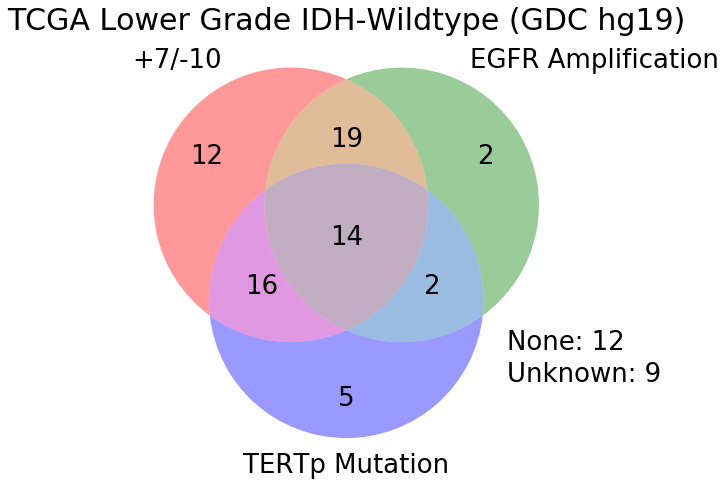

In [19]:
########## plot ###############
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
 
# Make the diagram
fig, ax = plt.subplots(figsize=(15, 8))
colors = []
v=venn3_unweighted(subsets = (len(hg19_710_only_idxs), len(hg19_egfr_only_idxs), 
                              len(hg19_710_egfr_idxs), len(hg19_tertp_only_idxs), 
                              len(hg19_710_tertp_idxs),len(hg19_egfr_tertp_idxs),len(hg19_all_idxs)), 
      set_labels=('+7/-10', 'EGFR Amplification', 'TERTp Mutation'))

for text in v.set_labels:
    text.set_fontsize(26)
for text in v.subset_labels:
    text.set_fontsize(26)

plt.text(x = 0.5, y=-0.35, s=r"None: " + str(pedatric_like_num), color='black', fontsize=26)
plt.text(x = 0.5, y=-0.45, s=r"Unknown: " + str(unknown_num), color='black', fontsize=26)
ax.set_title('TCGA Lower Grade IDH-Wildtype (GDC hg19)', fontsize=30)

plt.show()

# Supplemental Figures

## Supplemental 1

In [20]:
# # tcga chrarm scna data 
# ucsc_hg19_scna_df = pd.read_csv('../data/chrarm_data/ucsc_hg19_tcga_train_scna_chrarm_level.csv', index_col=0)
# tcga_hg19_scna_df = pd.read_csv('../data/chrarm_data/gdc_hg19_tcga_train_scna_chrarm_level.csv', index_col=0)
# tcga_hg38_scna_df = pd.read_csv('../data/chrarm_data/gdc_hg38_tcga_train_scna_chrarm_level.csv', index_col=0)

# # plot
# suspected_oligodendrogliomas = ['TCGA-HT-8113', 'TCGA-S9-A6WI', 'TCGA-FG-8189', 'TCGA-E1-A7YY', 'TCGA-DU-A7TG']
# title_dict = {'TCGA-HT-8113':'G2, IDH-mutant, ATRX-WT, TP53-WT; OS=30 months (alive)', 
#               'TCGA-S9-A6WI':'G2, IDH-mutant, ATRX-WT, TP53-WT; OS=85 months (alive)', 
#               'TCGA-FG-8189':'G2, IDH-mutant, ATRX-WT, TP53-WT; OS=23 months (alive)', 
#               'TCGA-E1-A7YY':'G2, IDH-mutant, ATRX-WT, TP53-WT; OS=146 months (dead)', 
#               'TCGA-DU-A7TG':'G2, IDH-mutant, ATRX-WT, TP53-WT; OS=44 months (dead)'}
# for idx in suspected_oligodendrogliomas:
#     title = title_dict[idx]
#     plot_df = pd.DataFrame([tcga_hg19_scna_df.loc[idx],tcga_hg38_scna_df.loc[idx],ucsc_hg19_scna_df.loc[idx]],
#                             index=['GDC, hg19', 'GDC, hg38', 'UCSC, hg19' ])[COL_ORDER]
#     # plot
#     fig, ax = plt.subplots(figsize=(20, 4))
#     sns.heatmap(plot_df, cmap="vlag", vmin=-1, vmax=1, ax=ax)
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=20)
#     plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=24)
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=20)
#     plt.title(title, fontsize=26)
#     plt.tight_layout()

## Supplemental 2A

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


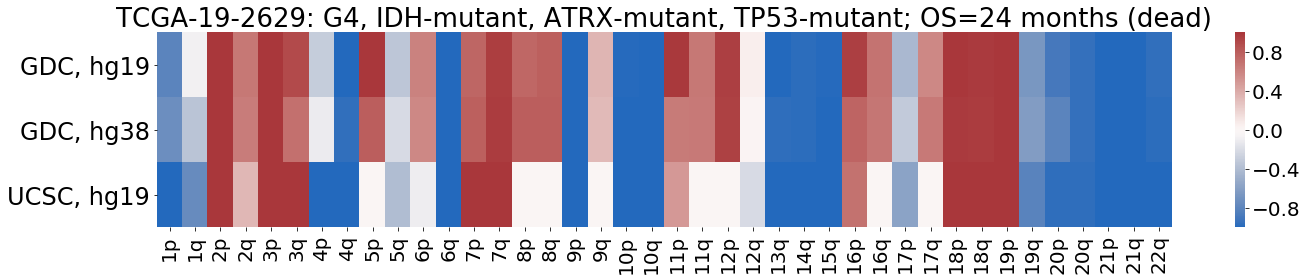

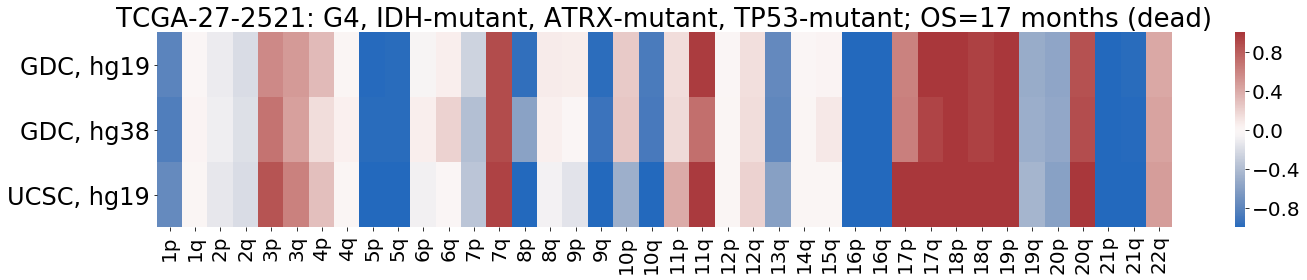

In [21]:
_idxs = ['TCGA-19-2629', 'TCGA-27-2521']

title_dict = {'TCGA-27-2521':'TCGA-27-2521: G4, IDH-mutant, ATRX-mutant, TP53-mutant; OS=17 months (dead)',
             'TCGA-19-2629':'TCGA-19-2629: G4, IDH-mutant, ATRX-mutant, TP53-mutant; OS=24 months (dead)'}
key_cols = ['Histologic_Grade', 'OS', 'OS_EVENT', 'EGFR_GDC_hg19', 'ATRX', 'TP53']
for idx in _idxs:
    title = title_dict[idx]
    plot_df = pd.DataFrame([tcga_hg19_scna_df.loc[idx],tcga_hg38_scna_df.loc[idx],ucsc_hg19_scna_df.loc[idx]],
                            index=['GDC, hg19', 'GDC, hg38', 'UCSC, hg19' ])[COL_ORDER]
    # plot
    fig, ax = plt.subplots(figsize=(20, 4))
    sns.heatmap(plot_df, cmap="vlag", vmin=-1, vmax=1, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=24)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=20)
    plt.title(title, fontsize=26)
    plt.tight_layout()

## Supplemental 2B

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


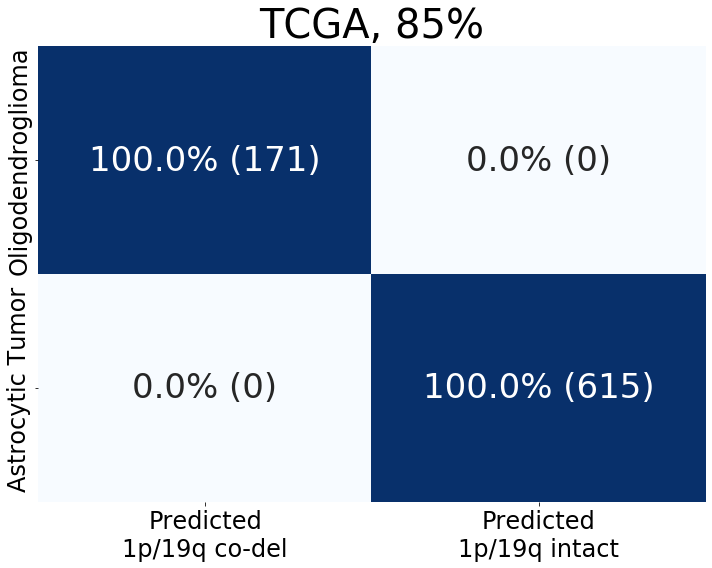

In [22]:
# SCNA data
tcga_1p19q_df = pd.read_csv('../data/chrarm_data/tcga_train_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)

# oliogdendroglioma predictions
thresh = 0.85
tcga_oligo_85_df = tcga_1p19q_df.loc[(tcga_1p19q_df['1p_GDC_hg19'] < -thresh)
                                              & (tcga_1p19q_df['1q_GDC_hg19'] >= -thresh)
                                              & (tcga_1p19q_df['19p_GDC_hg19'] >= -thresh)
                                              & (tcga_1p19q_df['19q_GDC_hg19'] < -thresh)]
pred_oligo_idxs = tcga_oligo_85_df.index.tolist()
pred_not_oligo_idxs = [x for x in tcga_1p19q_df.index if x not in pred_oligo_idxs]

# oliogdendroglioma ground truth
gt_oligo_idxs = tcga_clinical_df.loc[(tcga_clinical_df['WHO_2021_Subtype'].isin(['Oligodendroglioma']))].index
gt_not_oligo_idxs = tcga_clinical_df.loc[(tcga_clinical_df['WHO_2021_Subtype']\
                                          .isin(['IDH-Wildtype Glioblastoma','IDH-Mutant Astrocytoma']))].index

# TP/FN/TN/FP
TP = [x for x in gt_oligo_idxs if x in pred_oligo_idxs]
FN = [x for x in gt_oligo_idxs if x in pred_not_oligo_idxs]
TN = [x for x in gt_not_oligo_idxs if x in pred_not_oligo_idxs]
FP = [x for x in gt_not_oligo_idxs if x in pred_oligo_idxs]

## plot labels
cols = ['Predicted\n1p/19q co-del', 'Predicted\n1p/19q intact']
indices = ['Oligodendroglioma', 'Astrocytic Tumor']
plot_cm_df = pd.DataFrame(data=[[len(TP), len(FN)], [len(FP), len(TN)]], index=indices, columns=cols)

TP_label = str(np.round(len(TP) / (len(TP)+ len(FN))*100,1))+ '% ('+str(len(TP))+')'
FN_label = str(np.round(len(FN) / (len(TP)+ len(FN))*100,1))+ '% ('+str(len(FN))+')'
FP_label = str(np.round(len(FP) / (len(FP)+ len(TN))*100,1))+ '% ('+str(len(FP))+')'
TN_label = str(np.round(len(TN) / (len(FP)+ len(TN))*100,1))+ '% ('+str(len(TN))+')'
labels = [[TP_label,FN_label],[FP_label,TN_label]]

## plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap((plot_cm_df.T/np.sum(plot_cm_df, axis=1)).T, annot=np.asarray(labels), 
            fmt = '', cmap='Blues', annot_kws={"size": 34}, cbar=False, ax=ax)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24, va="center")
plt.title('TCGA, 85%', fontsize=40)
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


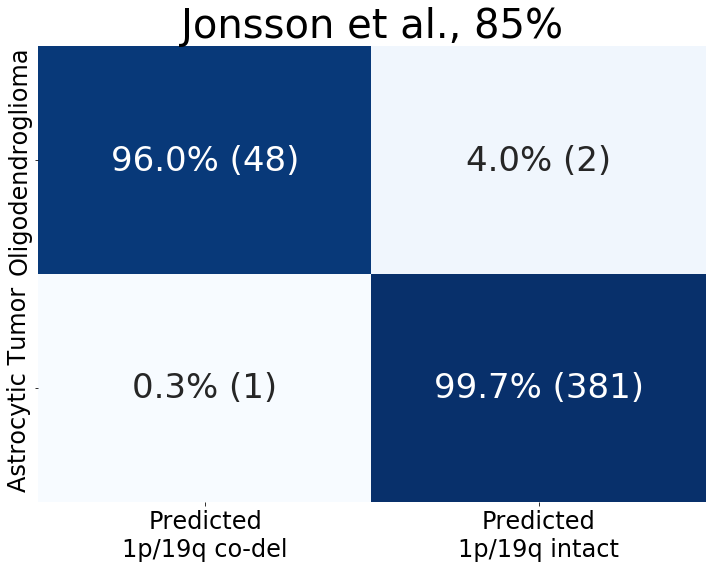

In [23]:
# SCNA data
jonsson_1p19q_df = pd.read_csv('../data/chrarm_data/jonsson_val_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)

# oliogdendroglioma predictions
thresh = 0.85
jonsson_oligo_85_df = jonsson_1p19q_df.loc[(jonsson_1p19q_df['1p'] < -thresh)
                                              & (jonsson_1p19q_df['1q'] >= -thresh)
                                              & (jonsson_1p19q_df['19p'] >= -thresh)
                                              & (jonsson_1p19q_df['19q'] < -thresh)]
pred_oligo_idxs = jonsson_oligo_85_df.index.tolist()
pred_not_oligo_idxs = [x for x in jonsson_1p19q_df.index if x not in pred_oligo_idxs]

# oliogdendroglioma ground truth
gt_oligo_idxs = jonsson_test_labels.loc[(jonsson_test_labels['WHO_2016_Subtype'].isin(['IDHmut-codel']))].index
gt_not_oligo_idxs = jonsson_test_labels.loc[(jonsson_test_labels['WHO_2016_Subtype']\
                                          .isin(['IDHwt','IDHmut-non-codel']))].index

# TP/FN/TN/FP
TP = [x for x in gt_oligo_idxs if x in pred_oligo_idxs]
FN = [x for x in gt_oligo_idxs if x in pred_not_oligo_idxs]
TN = [x for x in gt_not_oligo_idxs if x in pred_not_oligo_idxs]
FP = [x for x in gt_not_oligo_idxs if x in pred_oligo_idxs]

jonsson_FN = copy.deepcopy(FN)
jonsson_FP = copy.deepcopy(FP)

## plot labels
cols = ['Predicted\n1p/19q co-del', 'Predicted\n1p/19q intact']
indices = ['Oligodendroglioma', 'Astrocytic Tumor']
plot_cm_df = pd.DataFrame(data=[[len(TP), len(FN)], [len(FP), len(TN)]], index=indices, columns=cols)

TP_label = str(np.round(len(TP) / (len(TP)+ len(FN))*100,1))+ '% ('+str(len(TP))+')'
FN_label = str(np.round(len(FN) / (len(TP)+ len(FN))*100,1))+ '% ('+str(len(FN))+')'
FP_label = str(np.round(len(FP) / (len(FP)+ len(TN))*100,1))+ '% ('+str(len(FP))+')'
TN_label = str(np.round(len(TN) / (len(FP)+ len(TN))*100,1))+ '% ('+str(len(TN))+')'
labels = [[TP_label,FN_label],[FP_label,TN_label]]

## plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap((plot_cm_df.T/np.sum(plot_cm_df, axis=1)).T, annot=np.asarray(labels), 
            fmt = '', cmap='Blues', annot_kws={"size": 34}, cbar=False, ax=ax)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24, va="center")
plt.title('Jonsson et al., 85%', fontsize=40)
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


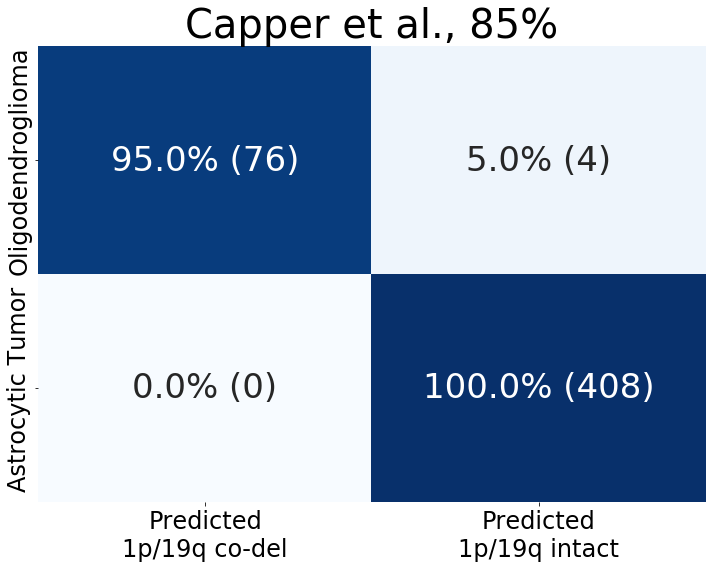

In [24]:
# SCNA data
jonsson_1p19q_df = pd.read_csv('../data/chrarm_data/capper_val_1p1q19p19q_avg_chrarm_loss.csv', index_col=0)

# oliogdendroglioma predictions
thresh = 0.85
jonsson_oligo_85_df = jonsson_1p19q_df.loc[(jonsson_1p19q_df['1p'] < -thresh)
                                              & (jonsson_1p19q_df['1q'] >= -thresh)
                                              & (jonsson_1p19q_df['19p'] >= -thresh)
                                              & (jonsson_1p19q_df['19q'] < -thresh)]
pred_oligo_idxs = jonsson_oligo_85_df.index.tolist()
pred_not_oligo_idxs = [x for x in jonsson_1p19q_df.index if x not in pred_oligo_idxs]

# oliogdendroglioma ground truth
gt_oligo_idxs = capper_test_labels.loc[(capper_test_labels['WHO_2016_Subtype'].isin(['IDHmut-codel']))].index
gt_not_oligo_idxs = capper_test_labels.loc[(capper_test_labels['WHO_2016_Subtype']\
                                          .isin(['IDHwt','IDHmut-non-codel']))].index

# TP/FN/TN/FP
TP = [x for x in gt_oligo_idxs if x in pred_oligo_idxs]
FN = [x for x in gt_oligo_idxs if x in pred_not_oligo_idxs]
TN = [x for x in gt_not_oligo_idxs if x in pred_not_oligo_idxs]
FP = [x for x in gt_not_oligo_idxs if x in pred_oligo_idxs]

capper_FN = copy.deepcopy(FN)
capper_FP = copy.deepcopy(FP)

## plot labels
cols = ['Predicted\n1p/19q co-del', 'Predicted\n1p/19q intact']
indices = ['Oligodendroglioma', 'Astrocytic Tumor']
plot_cm_df = pd.DataFrame(data=[[len(TP), len(FN)], [len(FP), len(TN)]], index=indices, columns=cols)

TP_label = str(np.round(len(TP) / (len(TP)+ len(FN))*100,1))+ '% ('+str(len(TP))+')'
FN_label = str(np.round(len(FN) / (len(TP)+ len(FN))*100,1))+ '% ('+str(len(FN))+')'
FP_label = str(np.round(len(FP) / (len(FP)+ len(TN))*100,1))+ '% ('+str(len(FP))+')'
TN_label = str(np.round(len(TN) / (len(FP)+ len(TN))*100,1))+ '% ('+str(len(TN))+')'
labels = [[TP_label,FN_label],[FP_label,TN_label]]

## plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap((plot_cm_df.T/np.sum(plot_cm_df, axis=1)).T, annot=np.asarray(labels), 
            fmt = '', cmap='Blues', annot_kws={"size": 34}, cbar=False, ax=ax)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24, va="center")
plt.title('Capper et al., 85%', fontsize=40)
plt.tight_layout()

## Supplemental 2C

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


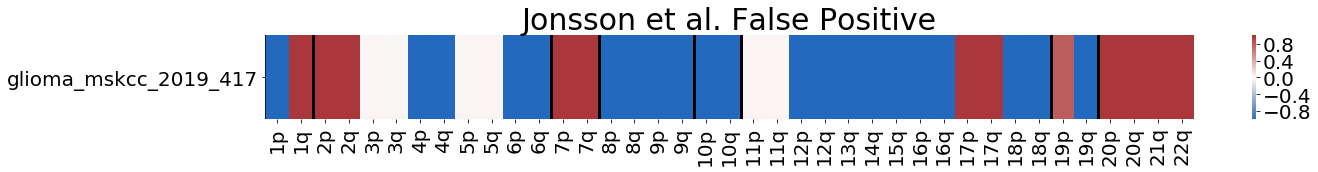

In [25]:
jonsson_scna_df = pd.read_csv('../data/chrarm_data/jonsson_scna_chrarm_level.csv', index_col=0)
sample_df = jonsson_scna_df.loc[jonsson_FP]
col_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p','5q', '6p', '6q', '7p', '7q', '8p', '8q', '9p', '9q', 
             '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', '18p', '18q', 
             '19p', '19q',  '20p', '20q',  '21q', '22q']
sample_df = sample_df[col_order]

yscale = 2.5
fig, ax = plt.subplots(figsize=(20, len(sample_df)*yscale))
sns.heatmap(sample_df, cmap="vlag", vmin=-1, vmax=1, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=20)

plt.axvline(x=0, color='k')
plt.axvline(x=2, color='k', linewidth=3)

plt.axvline(x=12, color='k', linewidth=3)
plt.axvline(x=14, color='k', linewidth=3)

plt.axvline(x=18, color='k', linewidth=3)
plt.axvline(x=20, color='k', linewidth=3)

plt.axvline(x=33, color='k', linewidth=3)
plt.axvline(x=35, color='k', linewidth=3)

plt.title('Jonsson et al. False Positive', fontsize=30)
plt.tight_layout()

## Supplemental 2D

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


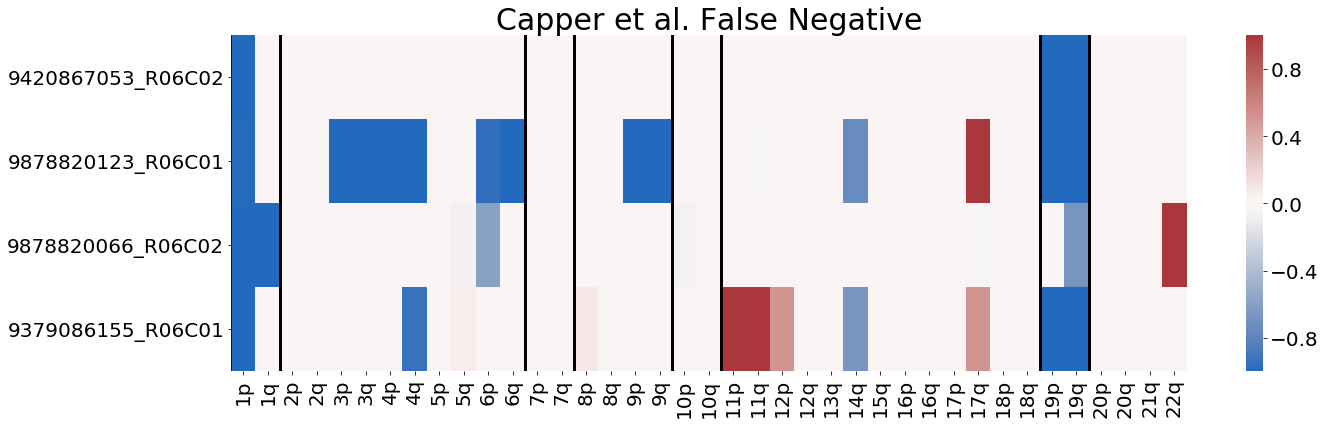

In [26]:
capper_scna_df = pd.read_csv('../data/chrarm_data/capper_scna_chrarm_level.csv', index_col=0)
sample_df = capper_scna_df.loc[capper_FN]
col_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p','5q', '6p', '6q', '7p', '7q', '8p', '8q', '9p', '9q', 
             '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', '18p', '18q', 
             '19p', '19q',  '20p', '20q',  '21q', '22q']
sample_df = sample_df[col_order]

yscale = 1.5
fig, ax = plt.subplots(figsize=(20, len(sample_df)*yscale))
sns.heatmap(sample_df, cmap="vlag", vmin=-1, vmax=1, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=20)

plt.axvline(x=0, color='k')
plt.axvline(x=2, color='k', linewidth=3)

plt.axvline(x=12, color='k', linewidth=3)
plt.axvline(x=14, color='k', linewidth=3)

plt.axvline(x=18, color='k', linewidth=3)
plt.axvline(x=20, color='k', linewidth=3)

plt.axvline(x=33, color='k', linewidth=3)
plt.axvline(x=35, color='k', linewidth=3)

plt.title('Capper et al. False Negative', fontsize=30)
plt.tight_layout()

## Supplemental 2E

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


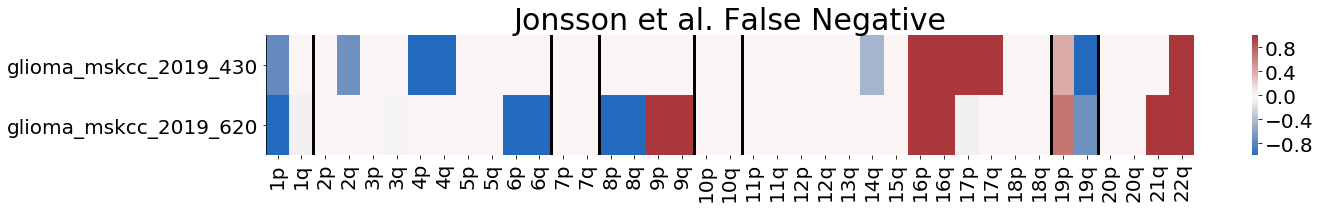

In [27]:
jonsson_scna_df = pd.read_csv('../data/chrarm_data/jonsson_scna_chrarm_level.csv', index_col=0)
sample_df = jonsson_scna_df.loc[jonsson_FN]
col_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p','5q', '6p', '6q', '7p', '7q', '8p', '8q', '9p', '9q', 
             '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', '18p', '18q', 
             '19p', '19q',  '20p', '20q',  '21q', '22q']
sample_df = sample_df[col_order]

yscale = 1.5
fig, ax = plt.subplots(figsize=(20, len(sample_df)*yscale))
sns.heatmap(sample_df, cmap="vlag", vmin=-1, vmax=1, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=20)

plt.axvline(x=0, color='k')
plt.axvline(x=2, color='k', linewidth=3)

plt.axvline(x=12, color='k', linewidth=3)
plt.axvline(x=14, color='k', linewidth=3)

plt.axvline(x=18, color='k', linewidth=3)
plt.axvline(x=20, color='k', linewidth=3)

plt.axvline(x=33, color='k', linewidth=3)
plt.axvline(x=35, color='k', linewidth=3)

plt.title('Jonsson et al. False Negative', fontsize=30)
plt.tight_layout()

## Supplemental 3A

## Supplemental 3B

## Supplemental 3C

## Supplemental 3D